In [3]:
from pymongo import MongoClient as mc
import pandas as pd
import seaborn as sns
import time
from datetime import datetime

In [4]:
start_time=time.time()
myClient = mc("mongodb://localhost:27017")
myDb = myClient['db_test']
myCol = myDb['checkout']
myQuery=myCol.aggregate([
    {"$match": { "target": "vergani" } },
    {"$unwind":"$cart"},
    {
        "$group": { 
            "_id" : {'$dateToString': {"format": '%Y-%m-%d', "date": '$date'}},
            "Total Orders": {"$sum":1}}
       },
    {"$project": {"_id":1,"Total Orders":1}}
])

dataToPerform = pd.DataFrame(myQuery).rename({'_id':'Date'}, axis=1)
print(dataToPerform)
mongodbTime=time.time() - start_time

          Date  Total Orders
0   2019-08-12             1
1   2019-07-30             7
2   2019-08-04             3
3   2019-08-03             9
4   2019-07-19             6
..         ...           ...
58  2019-06-11            10
59  2019-06-16             8
60  2019-07-16             3
61  2019-07-08            17
62  2019-06-12             8

[63 rows x 2 columns]


In [5]:
start_time1=time.time()
data = pd.json_normalize(list(myCol.find()), record_path='cart',meta=['target','date'])

#exctrating data(filtering data that we want)
data = data.query("target == 'vergani'")
dates = pd.to_datetime(data['date']).dt.date
target = pd.Series(data['target'])

dataToPerform =pd.DataFrame({'Date':dates,"Total Orders":target}).groupby('Date').aggregate({'Total Orders':'size'})

print(dataToPerform.reset_index())

pythonTime=time.time() - start_time1

          Date  Total Orders
0   2019-06-11            10
1   2019-06-12             8
2   2019-06-13             8
3   2019-06-14             8
4   2019-06-15             6
..         ...           ...
58  2019-08-08            43
59  2019-08-09            18
60  2019-08-10             6
61  2019-08-11            14
62  2019-08-12             1

[63 rows x 2 columns]


In [6]:
if mongodbTime<pythonTime:
    print("Mongo db is faster")
else:
    print("Python i faster")

Mongo db is faster


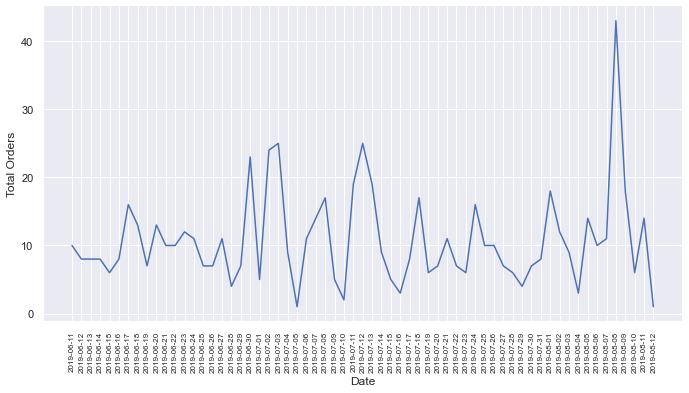

In [7]:
sns.set()
ax=sns.relplot(x='Date',y='Total Orders',data=dataToPerform,kind='line',aspect = 2) 
ax.set(xticks=dataToPerform.index)
ax.set_xticklabels(dataToPerform.index.values,rotation=90,fontsize=8)
